In [1]:
from nutils import *
import numpy, unittest

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections

In [2]:
nelems = 10
degree = 1
basistype = 'spline'
solvetol = 1e-10

In [3]:
# construct mesh
verts = numpy.linspace(0, numpy.pi/2, nelems+1)
domain, geom = mesh.rectilinear([verts, verts])

In [4]:
# create namespace
ns = function.Namespace()
ns.x = geom
ns.basis = domain.basis(basistype, degree=degree)
ns.u = 'basis_n ?lhs_n'
ns.fx = 'sin(x_0)'
ns.fy = 'exp(x_1)'

In [5]:
# construct residual
res = domain.integral('-basis_n,i u_,i' @ ns, geometry=ns.x, degree=degree*2)
res += domain.boundary['top'].integral('basis_n fx fy' @ ns, geometry=ns.x, degree=degree*2)

In [6]:
# construct dirichlet constraints
sqr = domain.boundary['left'].integral('u^2' @ ns, geometry=ns.x, degree=degree*2)
sqr += domain.boundary['bottom'].integral('(u - fx)^2' @ ns, geometry=ns.x, degree=degree*2)
cons = solver.optimize('lhs', sqr, droptol=1e-15)

optimize > iter 1 > solve > solver returned with residual 4e-17
optimize > constrained 21/121 dofs


In [7]:
# find lhs such that res == 0 and substitute this lhs in the namespace
lhs = solver.solve_linear('lhs', res, constrain=cons)
ns = ns(lhs=lhs)

solve > solver returned with residual 7e-15


L2 error: 9.85e-04


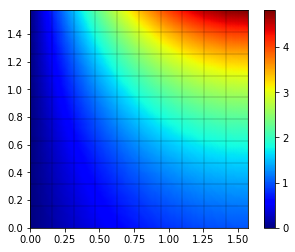

In [9]:
# plot solution
bezier = domain.sample('bezier', 9)
x, u = bezier.eval([ns.x, ns.u])

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
im = ax.tripcolor(x[:,0], x[:,1], bezier.tri, u, shading='gouraud', cmap='jet')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths=.1))
ax.autoscale(enable=True, axis='both', tight=True)
fig.colorbar(im)

# evaluate error against exact solution fx fy
err = domain.integrate('(u - fx fy)^2' @ ns, geometry=ns.x, degree=degree*2)**.5
log.user('L2 error: {:.2e}'.format(err))